<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Pipelines in Sklearn
<br>


---

### Learning Objectives
- Learn what a sklearn pipeline is and scenarios they are useful.
- Standardize data as part of a pipeline.
- Use pipelines with training and testing data.
- Practice object oriented programming and building a custom transformation in sklearn.
- Put the custom titanic preprocessor into a pipeline.
- Investigate the internals of sklearn pipelines.
- Practice using the `make_pipeline` function to easily create pipeline objects.


We usually start modeling with simple steps like:
- Reading and splitting prepared data into train/test subsets 
- Extracting target
- Extracting features
- Scaling & standardizing features
- handling outliers or missing values
- aggregating data to a suitable grain
- Iterate: choose model, fit, predict, print the scores

Then we want more features, and more models, and more tuning. . .

Example: http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

## Why use Pipeline instead of keeping the steps separate?

- It makes code more readable
- It keeps data during intermediate steps
- It makes it easy to change the order or add/remove steps
- You only have to call fit and predict once
- Joint parameter selection: grid search over parameters of all estimators at once

## Scikit learn provides the 'Pipeline' class to manage data science pipelines:

With it you can:
- Chain multiple preprocessors
- Add them with a classifier or regressor to create your custom modeling algorithm

**Important note:** In your pipeline, all your functions **except the last one** can be preprocessors. In other words, the last function might be any type (preprocessor, classifier or regressor).


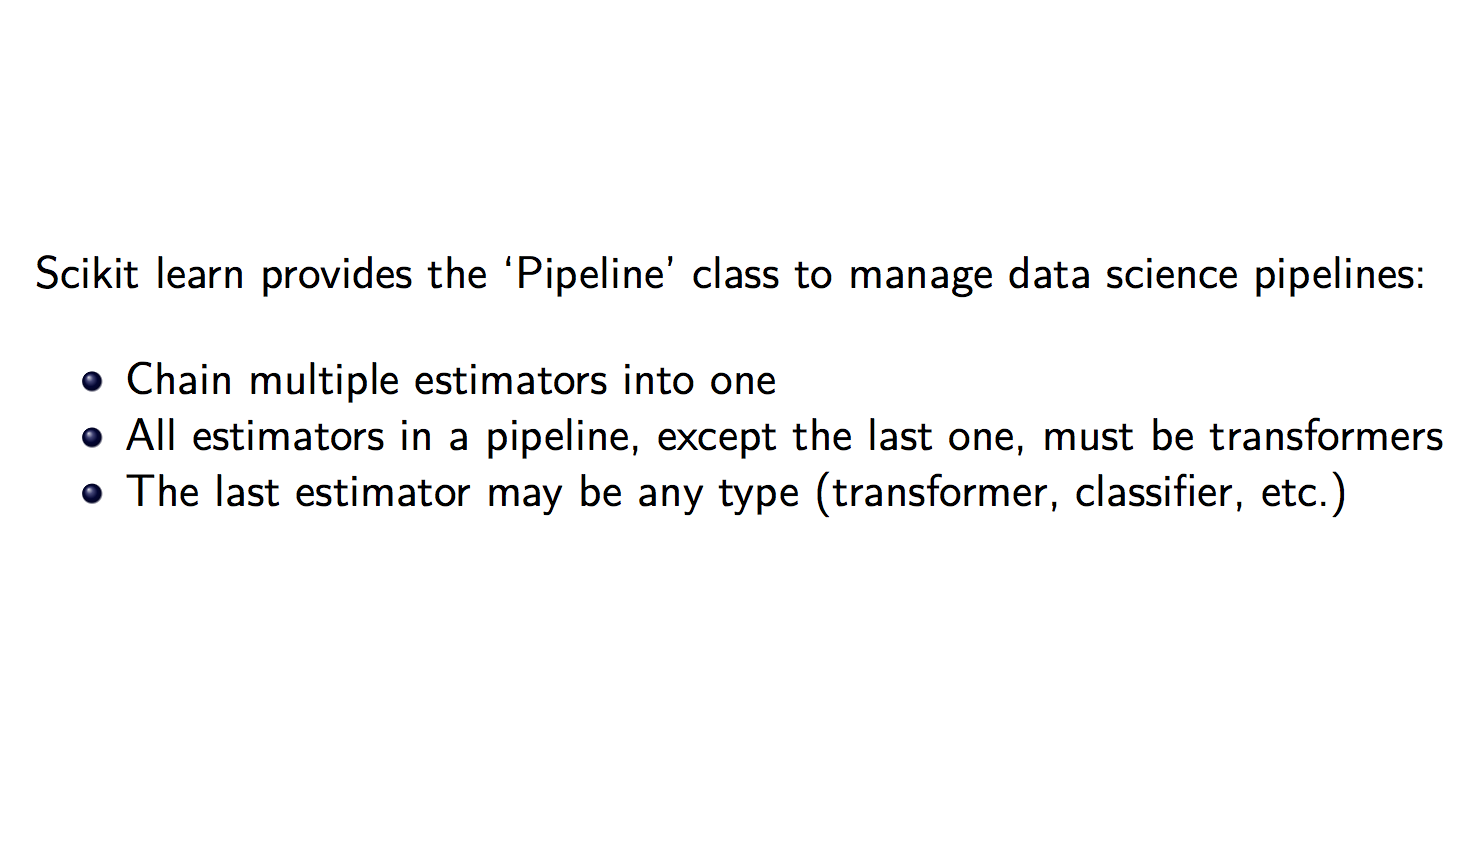

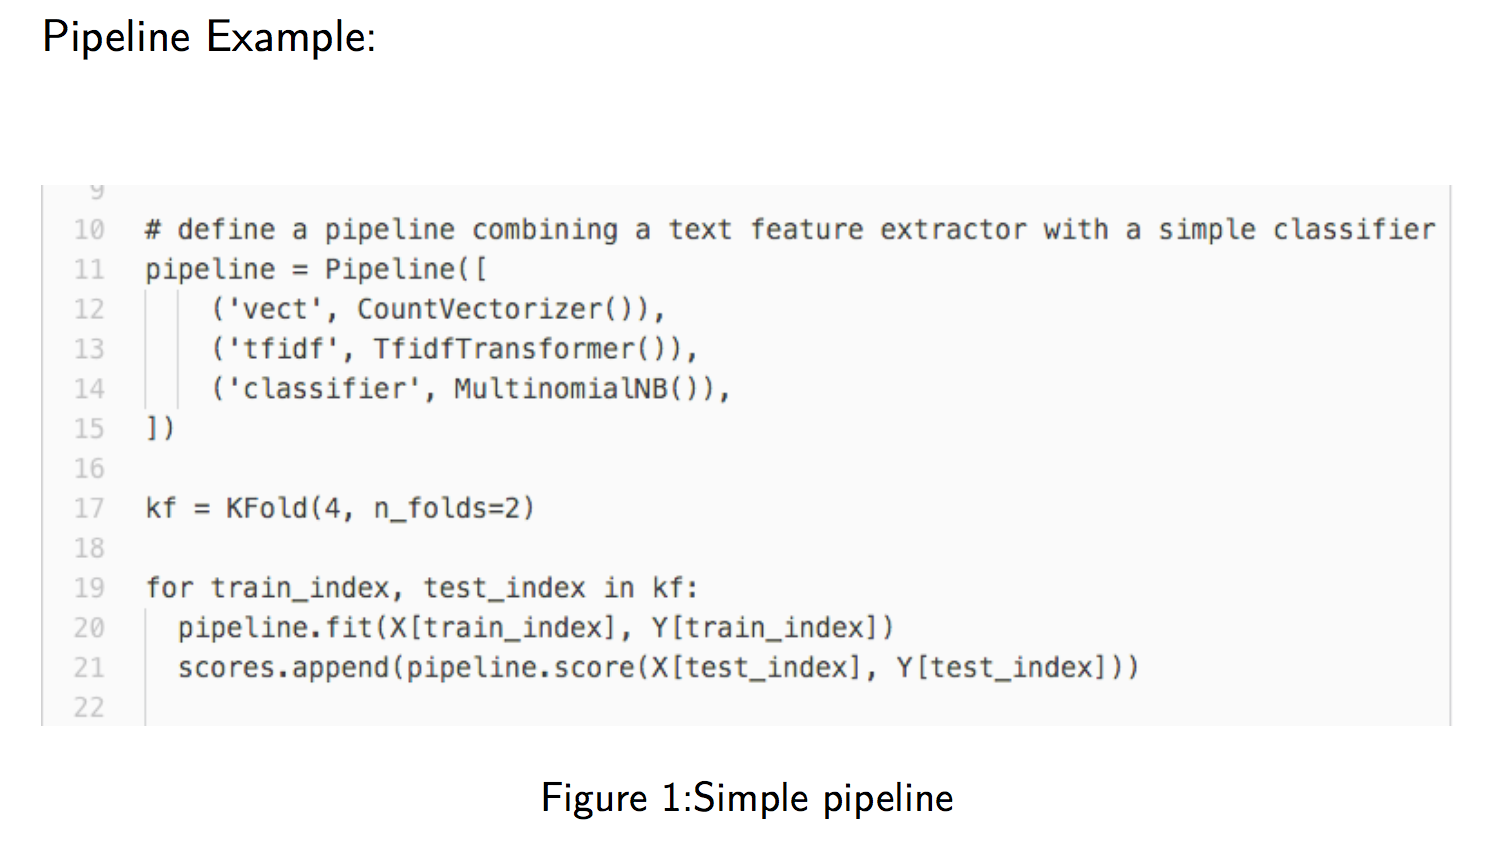

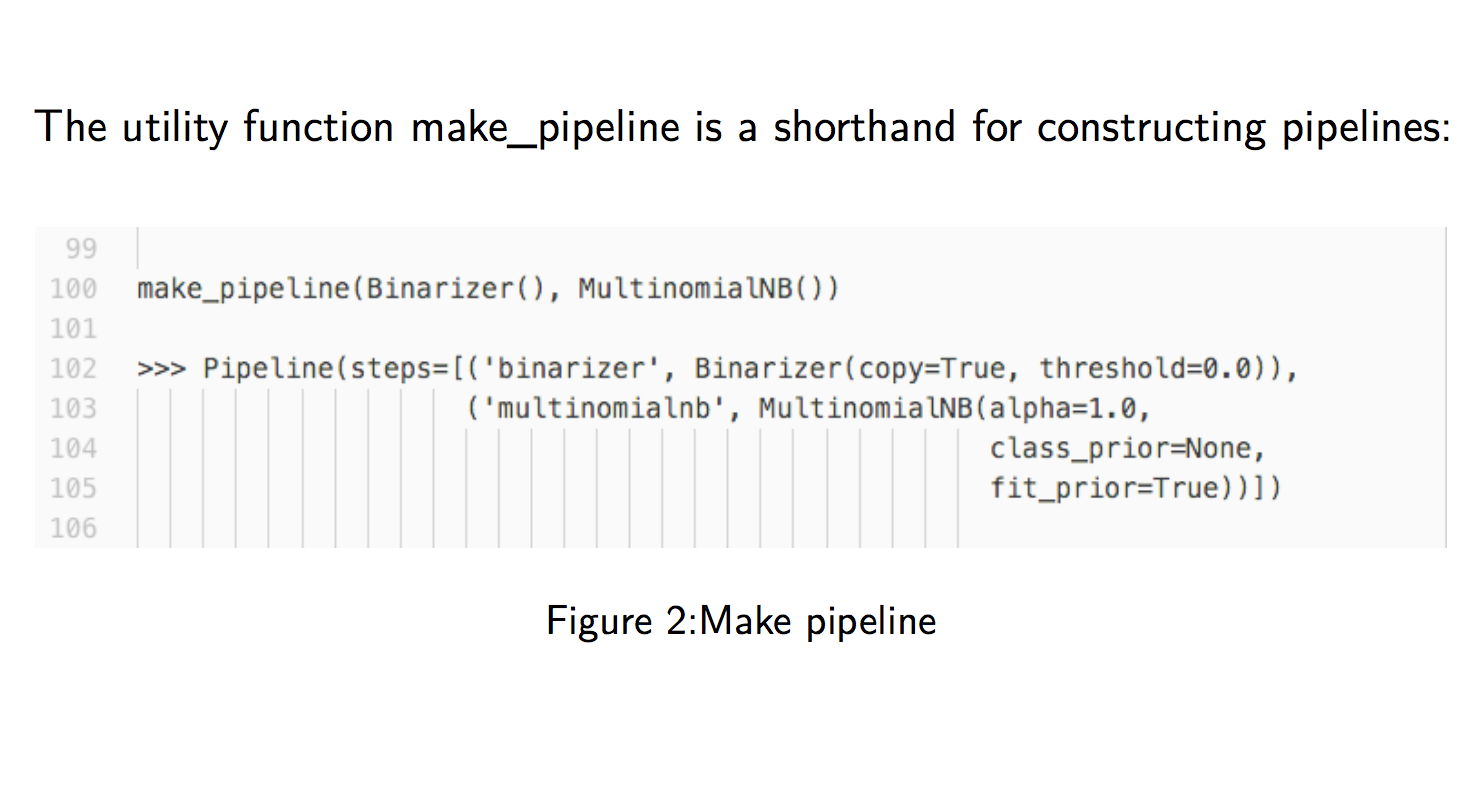

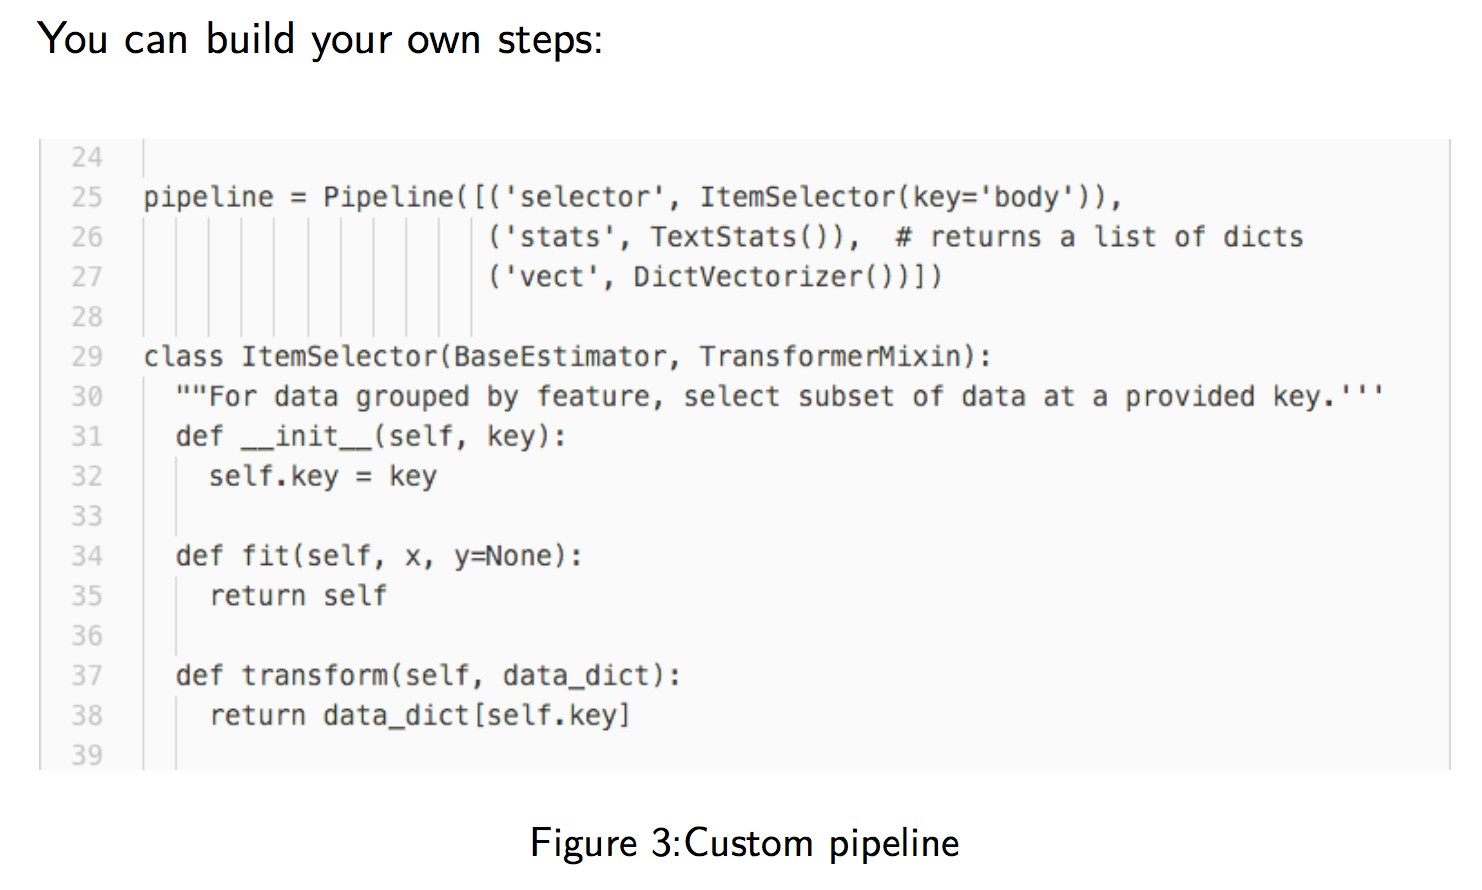

## All functions you use in your pipeline except the last one must be preprocessors (also called transformers):


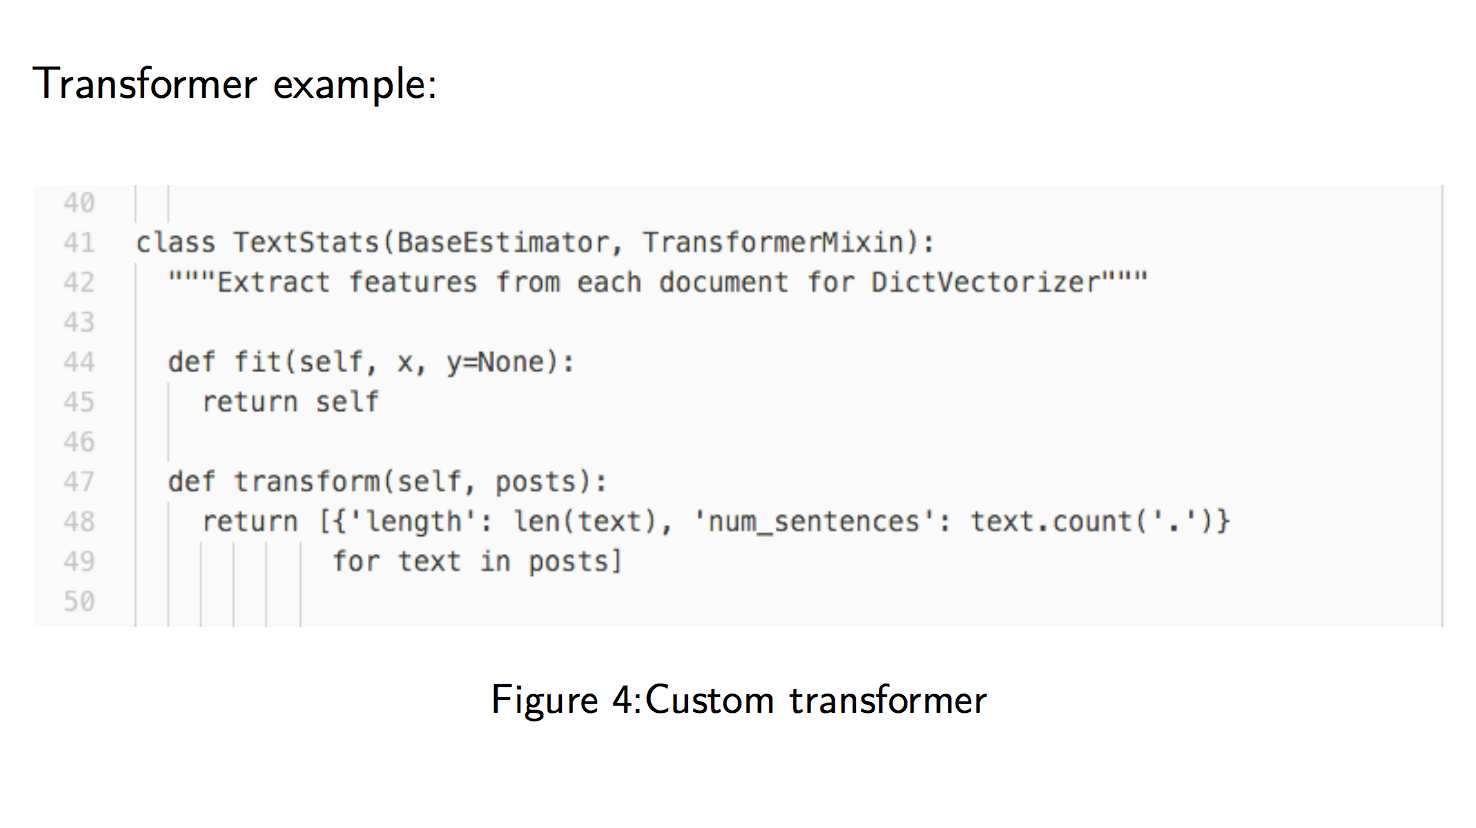

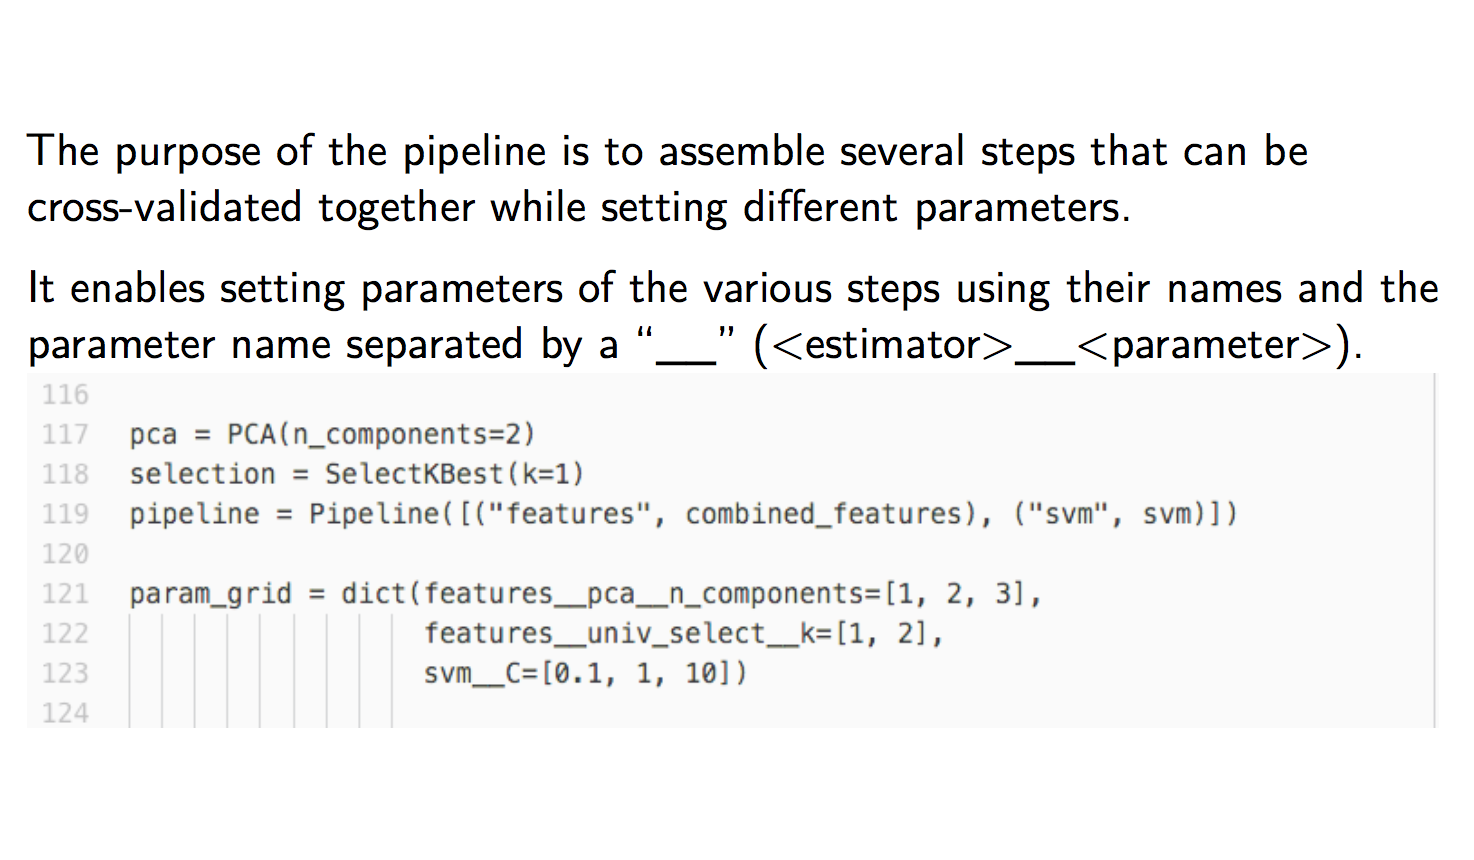

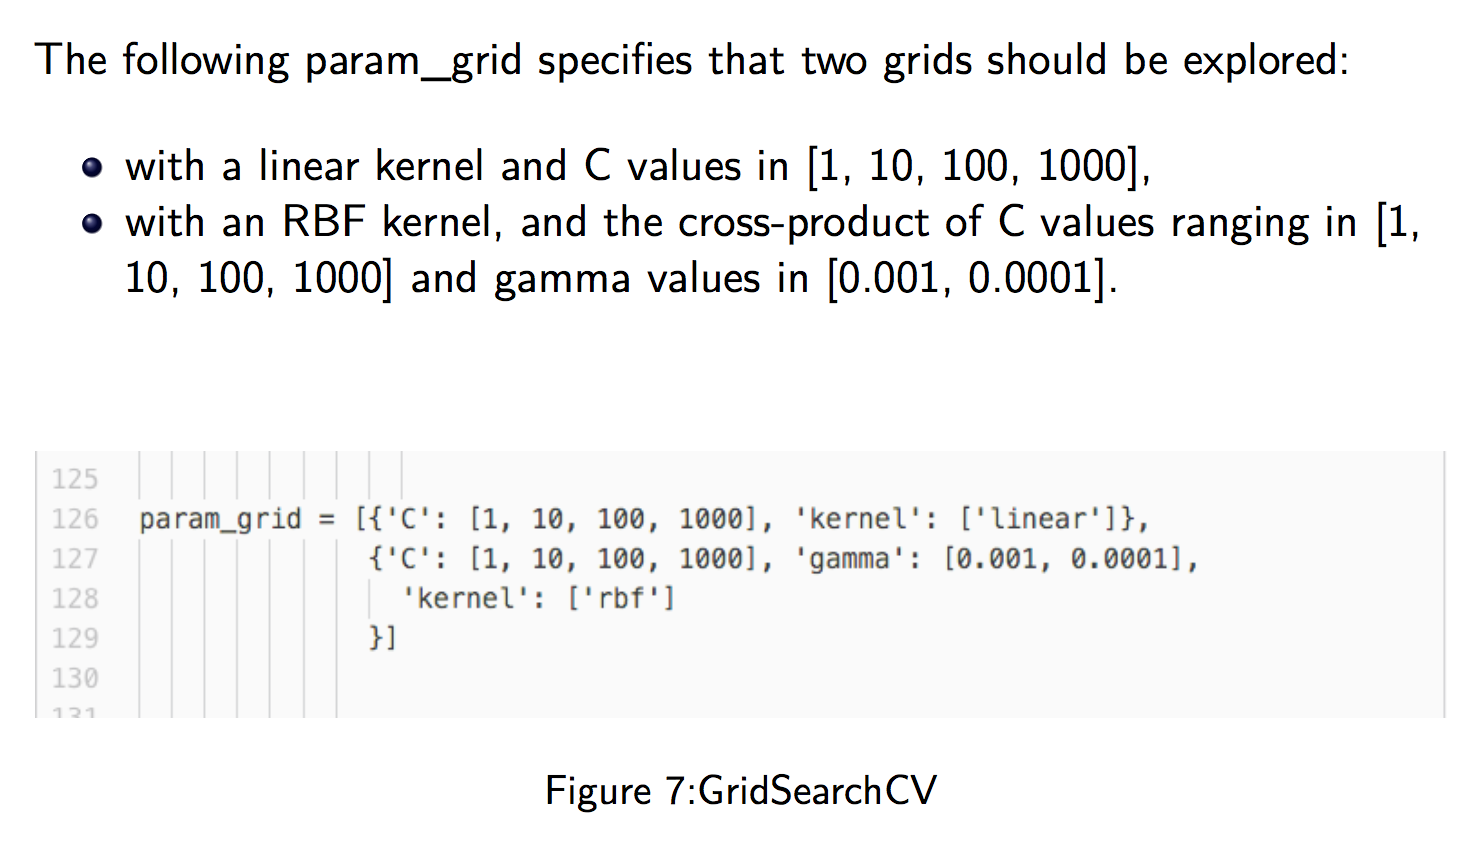

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Load the titanic data

In [31]:
titanic = pd.read_csv('./datasets/titanic_clean.csv')

<a id='pipe-objects'></a>

## Loading the pipeline objects

---

From the `sklearn.pipeline` module we are going to import `Pipeline` and `make_pipeline`.

`Pipeline` is the class object that will hold our data analysis process. The `make_pipeline` function is a convenience method that takes in a series of estimators or preprocessing steps and returns a `Pipeline` object.

We'll start with the more explicit construction using `Pipeline` and then move on to the convenience function.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


The term "pipeline" is jargon for a series of concatenated data transformations. Each stage of a pipeline feeds from the previous stage, i.e. the output of a stage is plugged into the input of the next stage and data flows through the pipeline from beginning to end.


![pipeline](./assets/pipeline.png)

---

Pipelines provide a higher level of abstraction than the individual building blocks of a data science process and are a nice and convenient way to organize analyses.

**Let's take a look at the titanic data:**

In [33]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


<a id='steps'></a>

## Processing steps for the titanic data

---

There are some preprocessing steps we're going to do before classifying whether or not passengers survived:

1. Remove unwanted columns ('PassengerId', 'Name')
- Convert categorical string or numeric columns to dummy coded columns.
- Standardize the predictor matrix.

For now we'll do this manually and then later integrate it into the pipeline.

In [34]:
data = titanic.drop(['PassengerId', 'Name'], axis=1)

In [35]:
def make_pclass_cols(df):
    #pclass 1 is reference class
    df['Pclass_2'] = df.Pclass.map(lambda x: 1 if x == 2 else 0)
    df['Pclass_3'] = df.Pclass.map(lambda x: 1 if x == 3 else 0)
    return df

In [36]:
def make_sex_cols(df):
    # male is reference class
    df['Female'] = df.Sex.map(lambda x: 1 if x == 'female' else 0)
    return df

In [37]:
def make_embarked_cols(df):
    # embarked S is reference class
    df['embarked_C'] = df.Embarked.map(lambda x: 1 if x == 'C' else 0)
    df['embarked_Q'] = df.Embarked.map(lambda x: 1 if x == 'Q' else 0)
    return df

In [38]:
data = make_pclass_cols(data)
data = make_sex_cols(data)
data = make_embarked_cols(data)

data.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [39]:
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Female,embarked_C,embarked_Q
0,0,3,22.0,1,0,7.2500,0,1,0,0,0
1,1,1,38.0,1,0,71.2833,0,0,1,1,0
2,1,3,26.0,0,0,7.9250,0,1,1,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,3,35.0,0,0,8.0500,0,1,0,0,0


<a id='standardize'></a>
## Using a pipeline to standardize the data and fit the model

---

Now we'll split the data up into the X, y predictor target format, standardize the X matrix, and fit a Logistic Regression model on Survived.

First, split into X, y:

In [40]:
y = data.pop('Survived')
X = data

Import the LogisticRegression and StandardScaler classes.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Next we're going to build one of these pipelines that can combine the steps. Below, we make the standard scaler object as well as the logistic regression object, then put them together into the pipeline object.

In [42]:
# A:

ss = StandardScaler()
lr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')

lr_pipe = Pipeline(steps=[('ss', ss),
                          ('logreg', lr)])


**Pipelines combine both pre-processing and model building steps into a single object**. 

Rather than manually building transformations and then feeding them into the models, pipelines tie both of these steps together.

Furthermore, pipelines are equipped with the methods of the final estimator step:

- `fit()` methods
- `predict()` and/or `predict_proba()`
- `score()`
- ... etc.

use the pipeline to fit the model:


In [9]:
# A:

What is the accuracy of your model?

In [ ]:
# A:

<a id='pipe-train-test'></a>

## Using pipelines with training and testing data

---

Next we'll split up this data into training and testing sets. One of the greatest benefits, in my opinion, to using pipelines is that the preprocessing steps before the model fitting retain the "fit" information from the training data to be applied to the testing data.

In the pipeline we built above, for example, the first standardization step is "fit" on the data we put into it. This means that the `StandardScaler` object takes the mean and standard deviation of that data and performs the procedure with those values.

It _also_ means that were we to predict or score on future data, the standard scaler in the pipeline would use the training data's mean and standard deviation to standardize that test data. This is what we want! You definitely don't want to standardize the training and testing data to their own means and standard deviations.

There are many scenarios in which the test data is actually data that we have not collected yet. In this case, you need to save the standardization procedure you used on the training data to use on this future data.

Split up into training and testing X, y below:


In [10]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

Fit the pipeline with the training data, then score it on the testing data:

In [11]:
# A:

**For the sake of example, standardize the Xtrain and Xtest separately and show that their normalization parameters differ.**

In [ ]:
sstrain = StandardScaler()
sstest = StandardScaler()
lr_sep = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')

Xtrain_n = sstrain.fit_transform(Xtrain)
Xtest_n = sstest.fit_transform(Xtest)

In [12]:
print sstrain.mean_ - sstest.mean_

<a id='built-in'></a>
## Built-in transformations and preprocessing steps

---

Sklearn comes with a wide variety of useful classes for preprocessing your data prior to model fitting that can be put into pipelines.

These can be found in the `sklearn.preprocessing` module and you should feel free to familiarize yourself with them if you want to make use of them in your code:

The preprocessing module comes loaded with many very useful pre-processing classes.

**Data Manipulators**

- Binarizer
- KernelCenterer
- MaxAbsScaler
- MinMaxScaler
- Normalizer
- OneHotEncoder
- PolynomialFeatures
- RobustScaler
- StandardScaler

**Data Imputation**

- Imputer

**Function Transformer**

- FunctionTransformer

**Label Manipulators**

- LabelBinarizer
- LabelEncoder
- MultiLabelBinarizer



<a id='custom'></a>
## Custom transformations

---

It's not always possible to use a built-in transformation class to do what you want. In fact, it's likely that you're going to run into a scenario where you need a customized preprocessing step before model fitting.

Let's take our titanic data, for example. Say we wanted a preprocessor that would remove the columns we didn't want and create the dummy-coded columns before sending it through to the standardization step.

Custom transformer classes start with this template code:


In [13]:
# we need to import the template classes to create a class that works like an sklearn class
from sklearn.base import BaseEstimator, TransformerMixin

# our "TitanicPreprocessor" is going to do the processing
class TitanticPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, **kwargs):
        return X

    def fit(self, X, **kwargs):
        return self

Some notes on this class:

1. We have to load in the `BaseEstimator` and `TransformerMixin` classes for our preprocessor to "inherit" from in the class definition.
- The two required functions are `fit` and `transform`, which will be used to chain the processes together in our pipeline.
- The `**kwargs` argument tells the function to expect an arbitrary number of arguments after whatever arguments were listed explicitly.

if you are confused about those classes, I recommand reading this article: http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/

**Here are the dummy-coding functions we wrote above to the class.**

In [14]:
class TitanticPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def make_pclass_cols(self, df):
        df['Pclass_2'] = df.Pclass.map(lambda x: 1 if x == 2 else 0)
        df['Pclass_3'] = df.Pclass.map(lambda x: 1 if x == 3 else 0)
        return df

    def make_sex_cols(self, df):
        df['Female'] = df.Sex.map(lambda x: 1 if x == 'female' else 0)
        return df

    def make_embarked_cols(self, df):
        df['embarked_C'] = df.Embarked.map(lambda x: 1 if x == 'C' else 0)
        df['embarked_Q'] = df.Embarked.map(lambda x: 1 if x == 'Q' else 0)
        return df

    def transform(self, X, *args):
        return X

    def fit(self, X, *args):
        return self

**Add a function to remove the unneccessary columns after dummy-coding:**

In [15]:
class TitanticPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    # add the functions here...
    
    
    def transform(self, X, **kwargs):
        return X

    def fit(self, X, **kwargs):
        return self

**Modify the `transform` function to perform these preprocessing steps, returning the new DataFrame.**

Also, keep track of the final column names in a class attribute.

In [16]:
class TitanticPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    # add the functions here...
    
    
    def transform(self, X, **kwargs):
        return X

    def fit(self, X, **kwargs):
        return self

<a id='custom-pipe'></a>
## Use the custom `TitanticPreprocessor` in a pipeline
---

We'll put it before the `StandardScaler` in our original pipeline.

In [17]:
tprep = TitanticPreprocessor()
ss = StandardScaler()
lr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')

# Fill the following:
lr_pipe = Pipeline(steps=[(...)])

Fit on the training data and test on the testing data like before, with the new pipeline. You'll need to create a new X, y with the original non-manually preprocessed data!

In [ ]:
y = titanic.Survived.values
X = titanic.drop('Survived', axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

In [18]:
lr_pipe.fit(Xtrain, ytrain)
lr_pipe.score(Xtest, ytest)

<a id='internals'></a>
## Looking at pipeline internals with `.get_params()`

---

Use the `.get_params()` function on the pipeline object to get out all of the parameters from the different steps as a dictionary.

In [19]:
lr_pipe.get_params()

You can pull out the feature names we stored by accessing our preprocessor object from the dictionary, then pulling out the attribute from that:

In [20]:
lr_pipe.get_params()['titanic_prep'].feature_names

<a id='make-pipe'></a>
## The `make_pipeline()` convenience function

---

`make_pipeline()` essentially does the same thing as `Pipeline`, the only difference being that you just insert your objects as arguments to the function and it will create the pipeline for you. This means that it will name the steps itself, rather than you doing it.

In [21]:
auto_pipe = make_pipeline(TitanticPreprocessor(), StandardScaler(), LogisticRegression())

In [ ]:
auto_pipe